# Step 1: Load Packages - No User Input Required

In [1]:
############################################
# Author: Jillian Stoller 
# Incrementality Testing Prep 
# DMA Clustering Notebook
# Last Updated 5/28/23
############################################

############## LOAD PACKAGES ####################

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
import random
import math
import itertools

# Display Max Column Width in tables
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid") #preferred visual style

###################################################


# Step 2: Update Variables - User Input Required

Load the input data by updating the variable `df`'s file name & file path. <br> Update the `dma_column_name` to have the name of the DMA Code / DMA column. This column will become the index.<br> <b>If the DMA Code is not the identifier/index, remove it so that the DMA Code does not get included as a feature.</b>

In [2]:
############## START OF USER INPUT ####################

#Load in scaled DMA Table file
df = pd.read_csv('Cluster_Analysis_Input.csv') #update file name & file path

#update variables
dma_column_name = "DMA_Code" #replace with the name of the DMA or DMA Code column (will become index)

The `random.seed` determines how the DMAs will be randomly sorted. After this code completes, check how the test cells compare in the most important features. If the first random sort is not ideal, change the random seed and restart the notebook. The random seed can be any number.

In [3]:
random.seed(10) #set random seed for DMA assignment

Control Group <br> <br>
Typically, the control group will be the same size as the other test cells. In this case, there is no need for a unique sized control group so the `unique_size_control_cell = 0`.  <br>  <br> In cases where the client specifically requested a realtively smaller control group (or any group that needs to be a different size than the others), update the variable `unique_size_control_cell = 1`.  <br> Then update the `control_group_size` to be equal to the desired realitve size. *Ex: 0.3 for 30% or 0.1 for 10%.* <br><br> We do not recommend going too small on the control group. Minimizing the size makes the control group vulnerable to noise or external factors that may be impacting one specific DMA.<br> *This can be ignored if the control group is not a unique size.*

In [4]:
unique_size_control_cell = 0 # 0 if control group same size as other test cells # 1 if control group is a unique size
control_group_size = 0.2 #size in fraction of how large the control group should be -default 0.3 / 30%

Naming the Test Groups <br><br>
Update the variable `test_cell_names` with the desired names for each test cell in list format. Must include a name for every desired test cell. Groups will be created based on the number of names in this list. <br>

If `unique_size_control_cell = 0`, include a name for the control group such as "Group Control" or "Control Group".<br>

If `unique_size_control_cell = 1`, do not include a control group in the list. The control group will be named "Control Group" as default.

In [5]:
test_cell_names = ["Group 1", "Group 2", "Group Control"] #label test cell names, must be the same size as number of test cells

Update the `chart_colors` to include the desired colors in the boxplots. It is recommended to use client's brand colors when possible. Should include a color for each test group.

In [6]:
chart_colors = ["#7f58af", "#64c5eb", "#e84d8a", "#feb326"] #give a color for each cell + control group + excluded group

############## END OF USER INPUT ####################

df.head()# preview the dataset

,DMA_Code,Population,New_Customer_Purchases,Paid_Search_Spend,Paid_Media_Spend,Affiliate_Conversions,GA_Search_Sessions
0,501,20831062,4477,368615,460426,1998,180381
1,803,15685611,3050,255641,300918,1191,117375
2,524,6326962,2103,138162,181496,991,70145
3,623,6990047,1397,120053,163285,723,59472
4,504,7951112,1554,111741,160358,534,47301


# Step 3: Data Processing & Dendrogram: No User Input Required

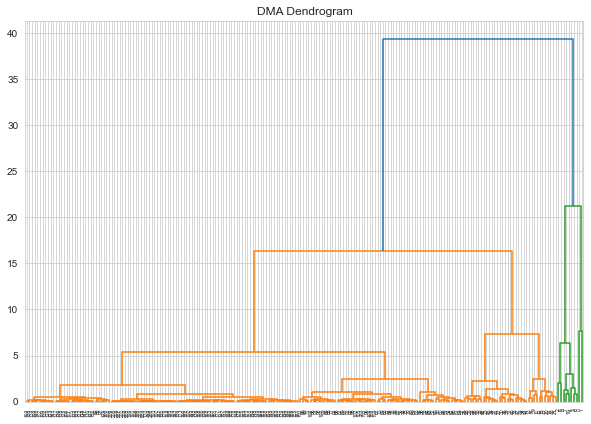

In [7]:
#Set DMA as index
df.set_index(dma_column_name, inplace = True)

#Apply standard scaler to variable columns
df_Scaled = (df - df.mean())/df.std()

#plot Dendrogram
plt.figure(figsize=(10, 7))
plt.title("DMA Dendrogram")

#apply the clustering to the scaled DMA dataset
clusters = sch.linkage(df_Scaled, 
            method='ward', 
            metric="euclidean")
sch.dendrogram(Z=clusters)
plt.show()

# Step 4: Select # of Clusters - User Input Required

The goal is to choose enough clusters that the most important characterisitics are captured, but not so many clusters that we are only looking at outliers. <br>
Start by looking at the second branch of the Dendrogram. Then draw a horizontal line across the dendrogram at that point. Count the number of vertical lines that the horizontal line crosses. This will give you the number of clusters in the dataset to start with.
<br><br>
The choice of the number of clusters is not always straightforward, and may require some trial and error. Experiment with different numbers and select one that groups the DMAs in a way that will divide them evenly across the test cells + control group. 

In [8]:
#select number of clusters clusters
num_clusters = 8

Running the Agglomerative Clustering Algorithm - No User Input Needed <br>

In [9]:
#apply agglomerative clustering algorithm
clustering_model = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
clustering_model.fit(df_Scaled)
labels = clustering_model.labels_

#apply cluster labels as new column in DMA Table
df["Cluster"] = clustering_model.labels_

#view number of DMAs in each cluster
df["Cluster"].value_counts(ascending=True)



4      1
7      1
6      2
0      6
2     11
5     24
1     62
3    103
Name: Cluster, dtype: int64

Above is showing the cluster label on the left and the number of DMAs in that cluster on the right.
<br><br>
*Note: This code will "Exclude" any DMAs that cannot be divided by the number of test cells.* <br><br>Ex - if there are 2 DMAs in a cluster, but there are 4 test cells, both DMAs will be excluded because they cannot be fairly represented in each group. <br> Ex - if there are 5 DMAs in a cluster, but there are 4 test cells, 4 DMAs will be randomly assigned a group and the fifth will be excluded. <br><br> Use your best judgement to include as many DMAs as possible, while excluding the true outliers (typically NYC, LA, Chicago, etc.) Change the number of clusters if necessary to make sure DMAs are being included fairly and rerun this section.

# Step 5: Visualize the Clusters based on the 2 main KPIs - User Input Required

update `col1` & `col2` with the column names of the most important metrics to see how the clusters have been assigned. 

In [10]:
col1 = 'Population' #Update with desired column name
col2 = 'New_Customer_Purchases' #Update with desired column name

<AxesSubplot:xlabel='Population', ylabel='New_Customer_Purchases'>

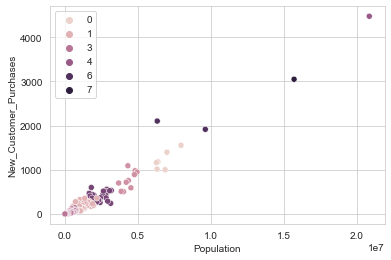

In [11]:
#plot how the clusters break out for Total Cafes & Subscriptions
data_labels = clustering_model.labels_
sns.scatterplot(x=col1, 
                y=col2, 
                data=df, 
                hue=data_labels)

# Step 6: Remove Outlier DMA Clusters from Available DMAs - No User Input Required

In [12]:
#Add DMA index column back into dataset as a traditional column
df.reset_index(inplace=True)

#update column name
df = df.rename(columns = {'index':dma_column_name})

#create cluster value dictionary
cluster_dict = df["Cluster"].value_counts(ascending=True).to_dict()

#create list to store the excluded cluster values
excluded_clusters = []

#loop through each cluster pair to determine if it should be excluded
for item in cluster_dict.items():
    #if the cluster has DMAs that have fewer DMAs than the # of test cells - exclude
    if item[1] < len(test_cell_names):
        excluded_clusters.append(item[0]) #store the cluster # to list
        
        
#remove excluded dmas from the cluster dictionary
for cluster in excluded_clusters:
    cluster_dict.pop(cluster)

#print cluster #'s that will be excluded    
excluded_clusters

[4, 7, 6]

# Step 7: Randomly Assign Clusters to Test Cells - No User Input Required

In [13]:
#Create empty list to store each cluster's unique DMAs
dma_clusters = []

#for every number of clusters, create a list of DMAs belonging to that cluster 
#append to master list of clusters
for cluster in range(num_clusters):
    cluster_list = df[df["Cluster"]==cluster][dma_column_name].to_list()
    dma_clusters.append(cluster_list)

        
#remove the outlier DMA groups
for group in dma_clusters:
    if len(group) < len(test_cell_names):
        dma_clusters.remove(group)


#create master list of each test cell's dmas
test_cell_DMA_list =[]


#create an empty list for each test cell
for i in range(len(test_cell_names)):
    test_cell_DMA_list.append([])


#if there is a control group
if unique_size_control_cell == 1:   

    #create list of control cell DMAs    
    control_cell_DMAs = []
    
    #loop through each cluster's dma list
    for cluster_group in dma_clusters:

        #determine number of DMAs per cell for the control group
        #round up the control group percentage * the number of DMAs in each cluster
        sample_size = math.ceil(control_group_size * len(cluster_group))
        #take random sample of DMAs based on control group size
        control_cell_DMAs.append(random.sample(cluster_group, sample_size))
        #flatten list of list into a singluar list
        control_cell_DMAs_list = list(itertools.chain.from_iterable(control_cell_DMAs))
        
    #remove control cell DMA list from DMAs to be distributed into the test cells
    for cluster_group in dma_clusters:
        for dma in cluster_group:
            if dma in control_cell_DMAs_list:
                cluster_group.remove(dma)
                
    #evenly distribute the remaining DMAs to the test groups based on their clusters
    #loop through each cluster list
    for cluster_group in dma_clusters:
        while len(cluster_group) > (len(test_cell_names)-1):
            try:
            #adding a random dma to each test cell group
                for cell in test_cell_DMA_list:
                    cell.append(cluster_group.pop(random.randrange(len(cluster_group))))
            except: ValueError
                
    #Create Dictionary of All DMAs & their associated test group
    #create empty master list to store list of all test cell's DMAs lists
    master_test_cell_DMA_list = []
    
    #for each test cell list of dmas, append them as a separate list to the master list
    for each_test_cell_list in test_cell_DMA_list:
        master_test_cell_DMA_list.append(each_test_cell_list)
    
    #append the control group dma list to the master test cells    
    master_test_cell_DMA_list.append(control_cell_DMAs_list)
    
    #Create Dictionary of each Test cell name & the list of DMAs in each test cell
    test_cell_names.append("Control Group") #Add the control group name to list of test cell names
    master_test_cell_DMA_dict = dict(zip(test_cell_names, master_test_cell_DMA_list))
    
    #print out summary info
    #count total grouped dmas
    count_grouped_dmas = 0
    
    for key in master_test_cell_DMA_dict:
        print("# of DMAs in", key,":", len(master_test_cell_DMA_dict[key]))
        count_grouped_dmas += len(master_test_cell_DMA_dict[key])
    
    print(count_grouped_dmas)
    print("Size of Control Group: " +  str(round(100 * len(master_test_cell_DMA_dict["Control Group"]) / (count_grouped_dmas))) + "%")
    print("\n")

#if there is a control group
if unique_size_control_cell == 0: 
    
    #evenly distribute the remaining DMAs to the test groups based on their clusters
    #loop through each cluster list
    for cluster_group in dma_clusters:
        while len(cluster_group) > (len(test_cell_names)-1):
            try:
            #adding a random dma to each test cell group
                for cell in test_cell_DMA_list:
                    cell.append(cluster_group.pop(random.randrange(len(cluster_group))))
            except: ValueError
                
    #Create Dictionary of All DMAs & their associated test group
    #create empty master list to store list of all test cell's DMAs lists
    master_test_cell_DMA_list = []
    
    #for each test cell list of dmas, append them as a separate list to the master list
    for each_test_cell_list in test_cell_DMA_list:
        master_test_cell_DMA_list.append(each_test_cell_list)
    

    
    #Create Dictionary of each Test cell name & the list of DMAs in each test cell
    #test_cell_names.append("Control Group") #Add the control group name to list of test cell names
    master_test_cell_DMA_dict = dict(zip(test_cell_names, master_test_cell_DMA_list))
    
    #print out summary info
    
    for key in master_test_cell_DMA_dict:
        print("# of DMAs in", key,":", len(master_test_cell_DMA_dict[key]))
        

# of DMAs in Group 1 : 67
# of DMAs in Group 2 : 67
# of DMAs in Group Control : 67


# Step 8: Apply the Cluster Labels to Dataset - No User Input Required

In [14]:
#define function that assigns the Test Cell label to each DMA in dataset
def Group_Label(row):
    for key, value in master_test_cell_DMA_dict.items():
        if row[dma_column_name] in value:
            return key
        

#apply the labelling function
df["Test_Cell"] = df.apply(lambda row: Group_Label(row), axis=1)

#Label the Excluded DMAs
df["Test_Cell"] = df["Test_Cell"].fillna('Excluded')

#sort table by Test Cell & DMA
df = df.sort_values(by=['Test_Cell',dma_column_name] , ascending=True)
df

,DMA_Code,Population,New_Customer_Purchases,Paid_Search_Spend,Paid_Media_Spend,Affiliate_Conversions,GA_Search_Sessions,Cluster,Test_Cell
0,501,20831062,4477,368615,460426,1998,180381,4,Excluded
20,517,2959243,505,44004,81781,297,26150,2,Excluded
2,524,6326962,2103,138162,181496,991,70145,6,Excluded
5,602,9613534,1916,128136,215272,1071,91997,6,Excluded
160,605,448265,47,3194,7574,14,1212,3,Excluded
101,698,639206,170,9374,14475,31,1734,1,Excluded
49,716,890408,219,15495,17749,34,2575,1,Excluded
17,751,4016549,504,48321,83196,303,31372,2,Excluded
1,803,15685611,3050,255641,300918,1191,117375,7,Excluded
86,503,660910,205,10292,14689,34,2294,1,Group 1


# Step 9: Results - Compare the Groups' Distributions Across Each Feature - No User Input Needed

The ideal groupings will have similar distributions across each group. Review how the sum, average, and distributions compare to get an idea on how well the DMAs were assigned. Ideally, each group should have a very similar distribution. If the groups do not look evenly distributed, re-run the code updating the `random.seed`

In [15]:
#output the sum of all metrics per test cell
df.pivot_table(index= "Test_Cell",  aggfunc=np.sum, fill_value=0)

,Affiliate_Conversions,Cluster,DMA_Code,GA_Search_Sessions,New_Customer_Purchases,Paid_Media_Spend,Paid_Search_Spend,Population
Test_Cell,,,,,,,,
Excluded,5930,32,5717,522941,12991,1362887,1010942,61410840
Group 1,4556,168,42325,412777,12716,1644705,961432,83591835
Group 2,4574,168,44549,397759,13640,1637878,969452,82679797
Group Control,4188,168,42041,380352,12260,1584987,894904,79769630


In [16]:
 #output the median of all metrics per test cell
df.pivot_table(index= "Test_Cell",  aggfunc=np.median, fill_value=0)

,Affiliate_Conversions,Cluster,DMA_Code,GA_Search_Sessions,New_Customer_Purchases,Paid_Media_Spend,Paid_Search_Spend,Population
Test_Cell,,,,,,,,
Excluded,303,3,605,31372,505,83196,48321,4016549
Group 1,32,3,617,2487,90,12079,7827,730426
Group 2,25,3,650,2349,81,13581,6494,794376
Group Control,26,3,598,2409,75,13253,6662,718629


# Step 10: Results - Compare the Groups' BoxPlots - User Input Required

Update `metric_column_name` for every important feature you want to see the boxplots for. Repeat as needed for multiple features.

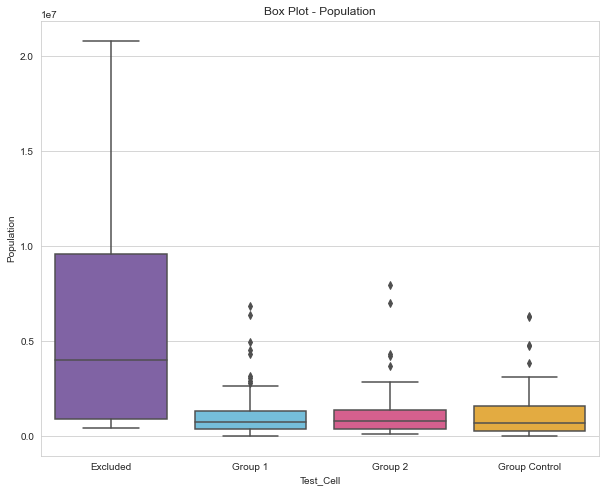

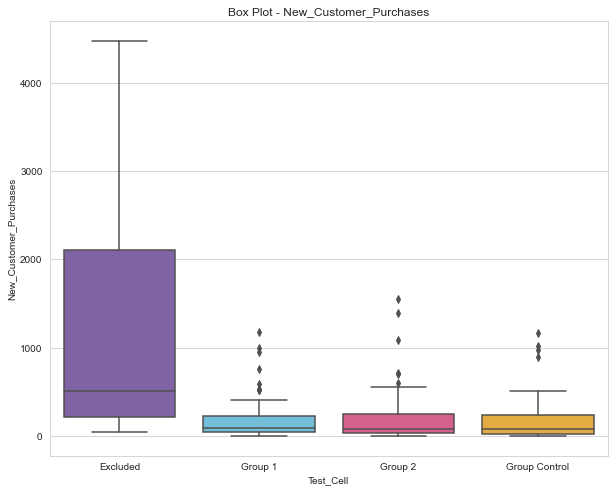

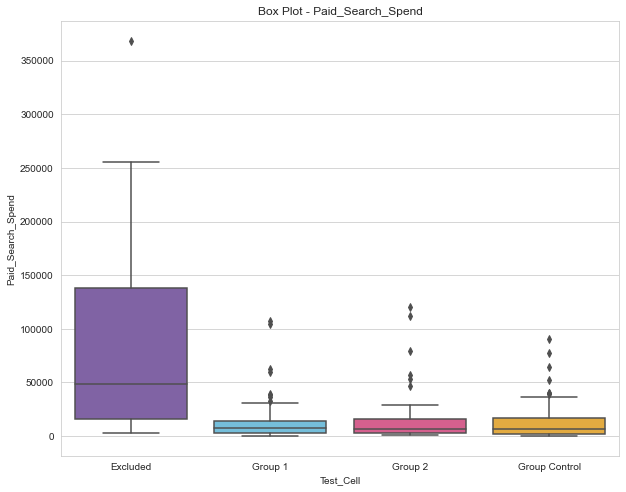

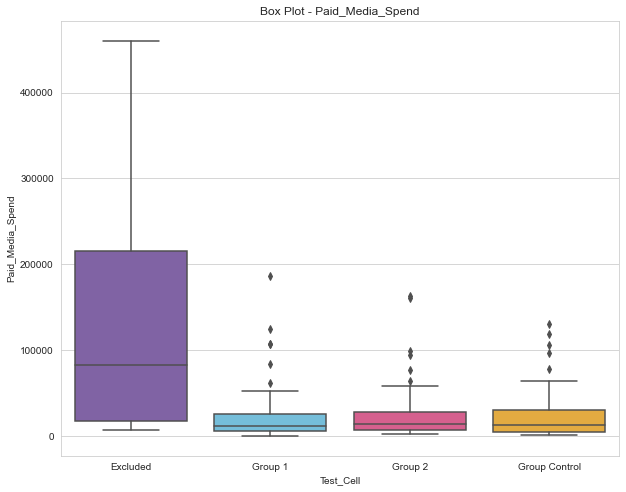

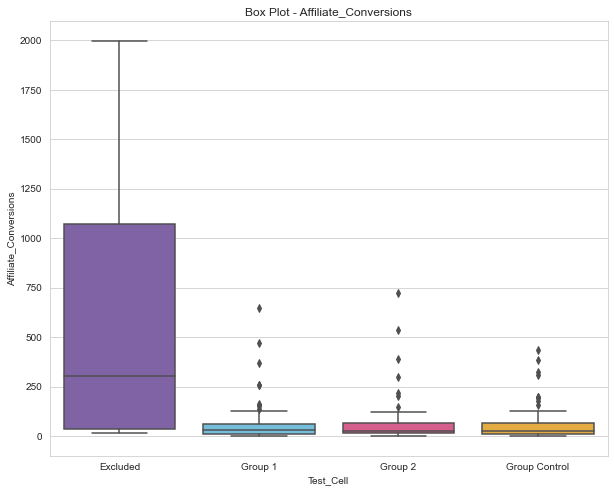

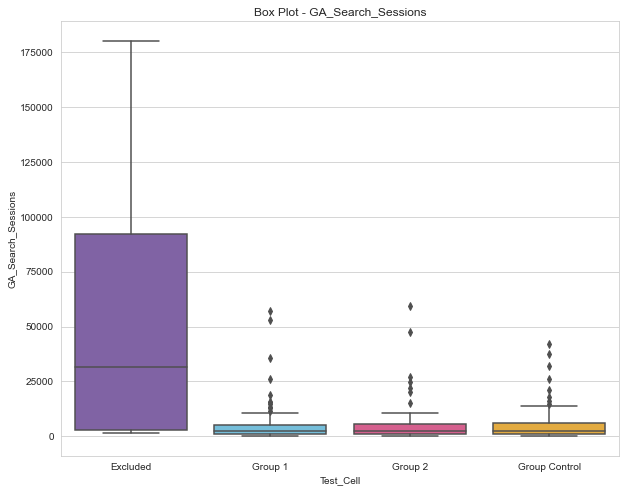

In [17]:
#generate a box plot for each column in the dataset that represents a feature
for col in df.columns:
    if col not in [dma_column_name, "Cluster", "Test_Cell"]:
        plt.figure(figsize=(10, 8))
        sns.boxplot(data = df, x = "Test_Cell", y = col, palette = chart_colors )
        plt.title(f"Box Plot - {col}")  # Add a title for the current column
        plt.show()  # Display the box plot

# Step 11: Export Dataset - User Input Required

Update file name & file path if needed. Default is "DMA_Test_Cells_YYYY-MM-DD".

In [18]:
#export final dataset
df.to_csv("DMA_Assigned_Test_Cells.csv", index = False)


df.head()

,DMA_Code,Population,New_Customer_Purchases,Paid_Search_Spend,Paid_Media_Spend,Affiliate_Conversions,GA_Search_Sessions,Cluster,Test_Cell
0,501,20831062,4477,368615,460426,1998,180381,4,Excluded
20,517,2959243,505,44004,81781,297,26150,2,Excluded
2,524,6326962,2103,138162,181496,991,70145,6,Excluded
5,602,9613534,1916,128136,215272,1071,91997,6,Excluded
160,605,448265,47,3194,7574,14,1212,3,Excluded
